In [ ]:
# default_exp diffquant_utils

# Utility Functions

## Array/Dict reformatting and transformation functions

In [ ]:
#export

def get_samples_used_from_samplemap(samplemap, cond1, cond2):
    samplemap_df = load_samplemap(samplemap)
    samples_c1 = samplemap_df[[cond1 in x for x in samplemap_df["condition"]]]["sample"] #subset the df to the condition
    samples_c2 = samplemap_df[[cond2 in x for x in samplemap_df["condition"]]]["sample"]
    return list(samples_c1), list(samples_c2)

In [ ]:
#export
import numpy as np
def filter_df_to_minrep(quant_df_wideformat, samples_c1, samples_c2, minrep):
    """filters dataframe in alphaquant format such that each column has a minimum number of replicates
    """
    quant_df_wideformat = quant_df_wideformat.replace(0, np.nan)
    df_c1_minrep = quant_df_wideformat[samples_c1].dropna(thresh = minrep, axis = 0)
    df_c2_minrep = quant_df_wideformat[samples_c2].dropna(thresh = minrep, axis = 0)
    idxs_both = df_c1_minrep.index.intersection(df_c2_minrep.index)
    quant_df_reduced = quant_df_wideformat.iloc[idxs_both].reset_index()
    return quant_df_reduced


In [ ]:
#export
def get_condpairname(condpair):
    return f"{condpair[0]}_VS_{condpair[1]}"

In [ ]:
#export
import os

def make_dir_w_existcheck(dir):
    if not os.path.exists(dir):
        os.makedirs(dir)

In [ ]:
#export
import os
def get_results_plot_dir_condpair(results_dir, condpair):
    results_dir_plots = f"{results_dir}/{condpair}_plots"
    make_dir_w_existcheck(results_dir_plots)
    return results_dir_plots

In [ ]:
#export
def get_middle_elem(sorted_list):
    nvals = len(sorted_list)
    if nvals==1:
        return sorted_list[0]
    middle_idx = nvals//2
    if nvals%2==1:
        return sorted_list[middle_idx]
    return 0.5* (sorted_list[middle_idx] + sorted_list[middle_idx-1])

In [ ]:
#export
import numpy as np
def get_nonna_array(array_w_nas):
    res = []
    isnan_arr = np.isnan(array_w_nas)

    for idx in range(len(array_w_nas)):
        sub_res = []
        sub_array = array_w_nas[idx]
        na_array = isnan_arr[idx]
        for idx2 in range(len(sub_array)):
            if not na_array[idx2]:
               sub_res.append(sub_array[idx2])
        res.append(np.array(sub_res))
    return np.array(res)

In [ ]:
#export
import numpy as np
def get_non_nas_from_pd_df(df):
    return {
        pep_name: sub_vals[~np.isnan(sub_vals)] for pep_name, sub_vals in
        zip( df.index.values, df.values)
    }

In [ ]:
#export
import numpy as np
def get_ionints_from_pd_df(df):
    return {
        pep_name: sub_vals for pep_name, sub_vals in
        zip( df.index.values, df.values)
    }

In [ ]:
#export
def invert_dictionary(my_map):
    inv_map = {}
    for k, v in my_map.items():
        inv_map[v] = inv_map.get(v, []) + [k]
    return inv_map

In [ ]:
#export
from scipy.stats import norm

def get_z_from_p_empirical(p_emp,p2z):
    p_rounded = np.format_float_scientific(p_emp, 1)
    if p_rounded in p2z:
        return p2z.get(p_rounded)
    z = norm.ppf(float(p_rounded))
    p2z[p_rounded] = z
    return z

In [ ]:
#export
import anytree
def get_levelnodes_from_nodeslist(nodeslist, level):
    levelnodes = []
    for node in nodeslist:
        precursors = anytree.findall(node, filter_= lambda x : (x.type == level))
        levelnodes.extend(precursors)
    return levelnodes

## I/O functions

In [ ]:
#export
def write_chunk_to_file(chunk, filepath ,write_header):
    """write chunk of pandas dataframe to a file"""
    chunk.to_csv(filepath, header=write_header, mode='a', sep = "\t", index = None)

## Documentation functions

In [ ]:
#export
import logging
import os
import sys


def set_logger(
    *,log_path = None,
    log_file_name="",
    stream: bool = True,
    log_level: int = logging.INFO,
    overwrite: bool = False,
) -> str:
    """Set the log stream and file.
    All previously set handlers will be disabled with this command.
    Parameters
    ----------
    log_file_name : str, None
        The file name to where the log is written.
        Folders are automatically created if needed.
        This is relative to the current path. When an empty string is provided,
        a log is written to the AlphaTims "logs" folder with the name
        "log_yymmddhhmmss" (reversed timestamp year to seconds).
        If None, no log file is saved.
        Default is "".
    stream : bool
        If False, no log data is sent to stream.
        If True, all logging can be tracked with stdout stream.
        Default is True.
    log_level : int
        The logging level. Usable values are defined in Python's "logging"
        module.
        Default is logging.INFO.
    overwrite : bool
        If True, overwrite the log_file if one exists.
        If False, append to this log file.
        Default is False.
    Returns
    -------
    : str
        The file name to where the log is written.
    """
    import time
    global PROGRESS_CALLBACK
    log_path = os.path.join(BASE_PATH, "logs")
    root = logging.getLogger()
    formatter = logging.Formatter(
        '%(asctime)s> %(message)s', "%Y-%m-%d %H:%M:%S"
    )
    root.setLevel(log_level)
    while root.hasHandlers():
        root.removeHandler(root.handlers[0])
    if stream:
        stream_handler = logging.StreamHandler(sys.stdout)
        stream_handler.setLevel(log_level)
        stream_handler.setFormatter(formatter)
        root.addHandler(stream_handler)
    if log_file_name is not None:
        if log_file_name == "":
            if not os.path.exists(log_path):
                os.makedirs(log_path)
            log_file_name = log_path
        log_file_name = os.path.abspath(log_file_name)
        if os.path.isdir(log_file_name):
            current_time = time.localtime()
            current_time = "".join(
                [
                    f'{current_time.tm_year:04}',
                    f'{current_time.tm_mon:02}',
                    f'{current_time.tm_mday:02}',
                    f'{current_time.tm_hour:02}',
                    f'{current_time.tm_min:02}',
                    f'{current_time.tm_sec:02}',
                ]
            )
            log_file_name = os.path.join(
                log_file_name,
                f"log_{current_time}.txt"
            )
        directory = os.path.dirname(log_file_name)
        if not os.path.exists(directory):
            os.makedirs(directory)
        if overwrite:
            file_handler = logging.FileHandler(log_file_name, mode="w")
        else:
            file_handler = logging.FileHandler(log_file_name, mode="a")
        file_handler.setLevel(log_level)
        file_handler.setFormatter(formatter)
        root.addHandler(file_handler)
    return log_file_name

In [ ]:
#export
import yaml
import os.path
import pathlib

def load_method_parameters(results_dir):
    params_file = f"{results_dir}/aq_parameters.yaml"
    return load_config(params_file)

def store_method_parameters(local_vars, results_dir):
    method_params = get_methods_dict_from_local_vars(local_vars)
    params_file = f"{results_dir}/aq_parameters.yaml"
    if os.path.exists(params_file):
        previous_params = load_method_parameters(results_dir)
        previous_params = {x:y for x, y in previous_params.items() if x not in method_params.keys()}
        method_params.update(previous_params)
    if not os.path.exists(f"{results_dir}/"):
        os.makedirs(f"{results_dir}/")
    with open(params_file, 'w') as outfile:
        yaml.dump(method_params, outfile, default_flow_style=False)

def get_methods_dict_from_local_vars(local_vars):
    method_params = {}
    for x in local_vars.keys():
        if (("_df" not in x) and ('condpair' not in x)):
            if ("input_file" in x) or ("results_dir" in x):
                method_params[x] = os.path.abspath(local_vars[x])
                try2 = pathlib.Path(local_vars[x]).absolute()
            else:
                method_params[x] = local_vars[x]
    return method_params

# Input Parsers
The Alphaquant pipeline is run using a generic wide-table input format, as specified in the documentation. The following parsers convert long format tables as provided e.g. by Spectronaut or DIA-NN into this generic format. The configuration for the parsers is set by a yaml file.

## Convert long format to wide format

### Parse .yaml file
The relevant parameters for reading and reformatting the long table are stored in the "intable_config.yaml" file. The functions below are for reading and reformating the config info

In [ ]:
#export
import yaml
import itertools

def get_relevant_columns(protein_cols, ion_cols, sample_ID, quant_ID, filter_dict):
    filtcols = []
    for filtconf in filter_dict.values():
        filtcols.append(filtconf.get('param'))
    relevant_cols = protein_cols + ion_cols + [sample_ID] + [quant_ID] + filtcols
    relevant_cols = list(set(relevant_cols)) # to remove possible redudancies
    return relevant_cols


def get_relevant_columns_config_dict(config_typedict):
    filtcols = []
    dict_ioncols = []
    for filtconf in config_typedict.get('filters', {}).values():
        filtcols.append(filtconf.get('param'))

    if 'ion_hierarchy' in config_typedict.keys():
        for headr in config_typedict.get('ion_hierarchy').values():
            ioncols = list(itertools.chain.from_iterable(headr.get("mapping").values()))
            dict_ioncols.extend(ioncols)
    quantID = config_typedict.get("quant_ID")
    if type(quantID) ==type("string"):
        quant_ids = [config_typedict.get("quant_ID")]
    elif quantID == None:
        quant_ids = []
    else:
        quant_ids = list(config_typedict.get("quant_ID").values())
    relevant_cols = config_typedict.get("protein_cols") + config_typedict.get("ion_cols", []) + [config_typedict.get("sample_ID")] + quant_ids + filtcols + dict_ioncols
    relevant_cols = list(set(relevant_cols)) # to remove possible redudancies
    return relevant_cols



def get_config_columns(config_dict):
    protein_cols = config_dict.get("protein_cols")
    ion_cols = config_dict.get("ion_cols")
    sample_ID = config_dict.get("sample_ID")
    quant_ID = config_dict.get("quant_ID")
    filter_dict = config_dict.get("filters", {})
    relevant_cols = get_relevant_columns(protein_cols, ion_cols, sample_ID, quant_ID, filter_dict)
    return relevant_cols, protein_cols, ion_cols, sample_ID, quant_ID, filter_dict


def load_config(config_yaml):
    stream = open(config_yaml, 'r')
    config_all = yaml.safe_load(stream)
    return config_all

def get_type2relevant_cols(config_all):
    type2relcols = {}
    for type in config_all.keys():
        config_typedict = config_all.get(type)
        relevant_cols = get_relevant_columns_config_dict(config_typedict)
        type2relcols[type] = relevant_cols
    return type2relcols

### Filter and reformat

In [ ]:
#export

def filter_input(filter_dict, input):
    for filtname,filterconf in filter_dict.items():
        param = filterconf.get('param')
        comparator = filterconf.get('comparator')
        value = filterconf.get('value')

        if comparator not in [">",">=", "<", "<=", "==", "!="]:
            raise TypeError(f"cannot identify the filter comparator of {filtname} given in the longtable config yaml!")

        if comparator=="==":
            input = input[input[param] ==value]
            continue
        try:
            input = input.astype({f"{param}" : "float"})
        except:
            pass

        if comparator==">":
            input = input[input[param].astype(type(value)) >value]

        if comparator==">=":
            input = input[input[param].astype(type(value)) >=value]

        if comparator=="<":
            input = input[input[param].astype(type(value)) <value]

        if comparator=="<=":
            input = input[input[param].astype(type(value)) <=value]

        if comparator=="!=":
            input = input[input[param].astype(type(value)) !=value]

    return input

In [ ]:
#export
def merge_protein_and_ion_cols(input_df, config_dict):
    protein_cols =  config_dict.get("protein_cols")
    ion_cols = config_dict.get("ion_cols")
    input_df['protein'] = input_df.loc[:, protein_cols].astype('string').sum(axis=1)
    input_df['ion'] = input_df.loc[:, ion_cols].astype('string').sum(axis=1)
    input_df = input_df.rename(columns = {config_dict.get('quant_ID') : "quant_val"})
    return input_df

In [ ]:
#export
import copy
def merge_protein_cols_and_ion_dict(input_df, config_dict):
    """[summary]

    Args:
        input_df ([pandas dataframe]): longtable containing peptide intensity data
        confid_dict ([dict[String[]]]): nested dict containing the parse information. derived from yaml file

    Returns:
        pandas dataframe: longtable with newly assigned "protein" and "ion" columns
    """
    protein_cols = config_dict.get("protein_cols")
    ion_hierarchy = config_dict.get("ion_hierarchy")
    splitcol2sep = config_dict.get('split_cols')
    quant_id_dict = config_dict.get('quant_ID')

    ion_dfs = []
    input_df['protein'] = input_df.loc[:, protein_cols].astype('string').sum(axis=1)

    input_df = input_df.drop(columns = [x for x in protein_cols if x!='protein'])
    for hierarchy_type in ion_hierarchy.keys():
        df_subset = input_df.copy()
        ion_hierarchy_local = ion_hierarchy.get(hierarchy_type).get("order")
        ion_headers_merged, ion_headers_grouped = get_ionname_columns(ion_hierarchy.get(hierarchy_type).get("mapping"), ion_hierarchy_local) #ion headers merged is just a helper to select all relevant rows, ionheaders grouped contains the sets of ionstrings to be merged into a list eg [[SEQ, MOD], [CH]]
        quant_columns = get_quantitative_columns(df_subset, hierarchy_type, config_dict, ion_headers_merged)
        headers = list(set(ion_headers_merged + quant_columns + ['protein']))
        if "sample_ID" in config_dict.keys():
            headers+=[config_dict.get("sample_ID")]
        df_subset = df_subset[headers].drop_duplicates()

        if splitcol2sep is not None:
            if quant_columns[0] in splitcol2sep.keys(): #in the case that quantitative values are stored grouped in one column (e.g. msiso1,msiso2,msiso3, etc.), reformat accordingly
                df_subset = split_extend_df(df_subset, splitcol2sep)
            ion_headers_grouped = adapt_headers_on_extended_df(ion_headers_grouped, splitcol2sep)

        #df_subset = df_subset.set_index(quant_columns)

        df_subset = add_merged_ionnames(df_subset, ion_hierarchy_local, ion_headers_grouped, quant_id_dict, hierarchy_type)
        ion_dfs.append(df_subset)
    input_df = pd.concat(ion_dfs, ignore_index=True)
    return input_df


def get_quantitative_columns(input_df, hierarchy_type, config_dict, ion_headers_merged):
    naming_columns = ion_headers_merged + ['protein']
    if config_dict.get("format") == 'longtable':
        quantcol = config_dict.get("quant_ID").get(hierarchy_type)
        return [quantcol]

    if config_dict.get("format") == 'widetable':
        quantcolumn_candidates = [x for x in input_df.columns if x not in naming_columns]
        if "quant_prefix" in config_dict.keys():
            return [x for x in quantcolumn_candidates if x.startswith(config_dict.get("quant_prefix"))] # in the case that the quantitative columns have a prefix (like "Intensity " in MQ peptides.txt), only columns with the prefix are filtered
        else:
            return quantcolumn_candidates #in this case, we assume that all non-ionname/proteinname columns are quantitative columns


def get_ionname_columns(ion_dict, ion_hierarchy_local):
    ion_headers_merged = []
    ion_headers_grouped = []
    for lvl in ion_hierarchy_local:
        vals = ion_dict.get(lvl)
        ion_headers_merged.extend(vals)
        ion_headers_grouped.append(vals)
    return ion_headers_merged, ion_headers_grouped


def adapt_headers_on_extended_df(ion_headers_grouped, splitcol2sep):
    #in the case that one column has been split, we need to designate the "naming" column
    ion_headers_grouped_copy = copy.deepcopy(ion_headers_grouped)
    for vals in ion_headers_grouped_copy:
        if splitcol2sep is not None:
            for idx in range(len(vals)):
                if vals[idx] in splitcol2sep.keys():
                    vals[idx] = vals[idx] + "_idxs"
    return ion_headers_grouped_copy

def split_extend_df(input_df, splitcol2sep, value_threshold=10):
    """reformats data that is stored in a condensed way in a single column. For example isotope1_intensity;isotope2_intensity etc. in Spectronaut

    Args:
        input_df ([type]): [description]
        splitcol2sep ([type]): [description]
        value_threshold([type]): [description]

    Returns:
        Pandas Dataframe: Pandas dataframe with the condensed items expanded to long format
    """
    if splitcol2sep==None:
        return input_df

    for split_col, separator in splitcol2sep.items():
        idx_name = f"{split_col}_idxs"
        split_col_series = input_df[split_col].str.split(separator)
        input_df = input_df.drop(columns = [split_col])

        input_df[idx_name] = [list(range(len(x))) for x in split_col_series]
        exploded_input = input_df.explode(idx_name)
        exploded_split_col_series = split_col_series.explode()

        exploded_input[split_col] = exploded_split_col_series.replace('', 0) #the column with the intensities has to come after to column with the idxs

        exploded_input = exploded_input.astype({split_col: float})
        exploded_input = exploded_input[exploded_input[split_col]>value_threshold]
        #exploded_input = exploded_input.rename(columns = {'var1': split_col})
    return exploded_input



def add_merged_ionnames(df_subset, ion_hierarchy_local, ion_headers_grouped, quant_id_dict, hierarchy_type):
    """puts together the hierarchical ion names as a column in a given input dataframe"""
    all_ion_headers = list(itertools.chain.from_iterable(ion_headers_grouped))
    columns_to_index = [x for x in df_subset.columns if x not in all_ion_headers]
    df_subset = df_subset.set_index(columns_to_index)

    rows = df_subset[all_ion_headers].to_numpy()
    ions = []

    for row in rows: #iterate through dataframe
        count = 0
        ionstring = ""
        for lvl_idx in range(len(ion_hierarchy_local)):
            ionstring += f"{ion_hierarchy_local[lvl_idx]}"
            for sublvl in ion_headers_grouped[lvl_idx]:
                ionstring+= f"_{row[count]}_"
                count+=1
        ions.append(ionstring)
    df_subset['ion'] = ions
    df_subset = df_subset.reset_index()
    if quant_id_dict!= None:
        df_subset = df_subset.rename(columns = {quant_id_dict.get(hierarchy_type) : "quant_val"})
    return df_subset

In [ ]:
#export
import os.path
def reformat_and_write_longtable_according_to_config_new(input_file, outfile_name, config_dict, sep = "\t",decimal = ".", enforce_largefile_processing = False, chunksize =1000_000):
    """Reshape a long format proteomics results table (e.g. Spectronaut or DIA-NN) to a wide format table.
    :param file input_file: long format proteomic results table
    :param string input_type: the configuration key stored in the config file (e.g. "diann_precursor")
    """
    filesize = os.path.getsize(input_file)/(1024**3) #size in gigabyte
    file_is_large = (filesize>10 and str(input_file).endswith(".zip")) or filesize>50 or enforce_largefile_processing

    if file_is_large:
        tmpfile_large = f"{input_file}.tmp.longformat.columnfilt.tsv" #only needed when file is large
        #remove potential leftovers from previous processings
        if os.path.exists(tmpfile_large):
            os.remove(tmpfile_large)
        if os.path.exists(outfile_name):
            os.remove(outfile_name)
    
    relevant_cols = get_relevant_columns_config_dict(config_dict)
    input_df_it = pd.read_csv(input_file, sep = sep, decimal=decimal, usecols = relevant_cols, encoding ='latin1', chunksize = chunksize)
    input_df_list = []
    header = True
    for input_df_subset in input_df_it:
        input_df_subset = adapt_subtable(input_df_subset, config_dict)
        if file_is_large:
            write_chunk_to_file(input_df_subset,tmpfile_large, header)
        else:
            input_df_list.append(input_df_subset)
        header = False
        
    if file_is_large:
        process_with_dask(tmpfile_columnfilt=tmpfile_large , outfile_name = outfile_name, config_dict=config_dict)
    else:
        input_df = pd.concat(input_df_list)
        input_reshaped = reshape_input_df(input_df, config_dict)
        input_reshaped.to_csv(outfile_name, sep = "\t", index = None)
    



In [ ]:
#export
import dask.dataframe as dd
import glob
import os
import shutil 

def adapt_subtable(input_df_subset, config_dict):
    input_df_subset = filter_input(config_dict.get("filters", {}), input_df_subset)
    if "ion_hierarchy" in config_dict.keys():
        return merge_protein_cols_and_ion_dict(input_df_subset, config_dict)
    else:
        return merge_protein_and_ion_cols(input_df_subset, config_dict)


def reshape_input_df(input_df, config_dict):
    input_df = input_df.astype({'quant_val': 'float'})
    input_reshaped = pd.pivot_table(input_df, index = ['protein', 'ion'], columns = config_dict.get("sample_ID"), values = 'quant_val', fill_value=0)
    if input_reshaped.iloc[:,0].replace(0, np.nan).median() <100: #when values are small, rescale by a constant factor to prevent rounding errors in the subsequent aq analyses
        input_reshaped = input_reshaped *10000

    input_reshaped = input_reshaped.reset_index()
    return input_reshaped


def process_with_dask(*,tmpfile_columnfilt, outfile_name, config_dict):
    df = dd.read_csv(tmpfile_columnfilt, sep = "\t")
    df = df.set_index('protein')
    sorted_filedir = f"{tmpfile_columnfilt}_sorted"
    df.to_csv(sorted_filedir, sep = "\t")
    #now the files are sorted and can be pivoted chunkwise (multiindex pivoting at the moment not possible in dask)
    files_dask = glob.glob(f"{sorted_filedir}/*part")
    header = True
    for file in files_dask:
        input_df = pd.read_csv(file, sep = "\t")
        input_reshaped = reshape_input_df(input_df, config_dict)
        write_chunk_to_file(input_reshaped, outfile_name, header)
        header = False
    os.remove(tmpfile_columnfilt)
    shutil.rmtree(sorted_filedir)


In [ ]:
#export
def reformat_and_write_wideformat_table(peptides_tsv, outfile_name, config_dict):
    input_df = pd.read_csv(peptides_tsv,sep="\t", encoding ='latin1')
    filter_dict = config_dict.get("filters")
    protein_cols = config_dict.get("protein_cols")
    ion_cols = config_dict.get("ion_cols")
    input_df = filter_input(filter_dict, input_df)
    #input_df = merge_protein_and_ion_cols(input_df, config_dict)
    input_df = merge_protein_cols_and_ion_dict(input_df, config_dict)
    if 'quant_prefix' in config_dict.keys():
        quant_prefix = config_dict.get('quant_prefix')
        headers = ['protein', 'ion'] + list(filter(lambda x: x.startswith(quant_prefix), input_df.columns))
        input_df = input_df[headers]
        input_df = input_df.rename(columns = lambda x : x.replace(quant_prefix, ""))

    input_df = input_df.reset_index()
    
    input_df.to_csv(outfile_name, sep = '\t', index = None)

In [ ]:

def read_mq_peptides_table(peptides_tsv, pepheader = "Sequence", protheader = "Leading razor protein"):
    peps = pd.read_csv(peptides_tsv,sep="\t", encoding ='latin1')
    peps = peps[peps["Reverse"] != "+"]
    peps = peps[peps["Potential contaminant"] != "+"]
    if pepheader != None:
        peps = peps.rename(columns = {pepheader : "ion"})
    if protheader != None:
        peps = peps.rename(columns = {protheader: "protein"})
    headers = ['protein', 'ion'] + list(filter(lambda x: x.startswith("Intensity "), peps.columns))
    peps = peps[headers]
    peps = peps.rename(columns = lambda x : x.replace("Intensity ", ""))

    return peps

In [ ]:
#export
from anytree.importer import JsonImporter
import os

def read_condpair_tree(cond1, cond2, results_folder = os.path.join(".", "results")):
    """reads the merged and clustered iontree for a given condpair"""
    condpairname = get_condpairname([cond1, cond2])
    tree_file =os.path.join(results_folder, f"{condpairname}.iontrees.json")
    if not os.path.isfile(tree_file):
        return None
    importer = JsonImporter()
    filehandle = open(tree_file, 'r')
    jsontree = importer.read(filehandle)
    filehandle.close()
    return jsontree

## check for already processed files

In [ ]:
#export
import os
def check_for_processed_runs_in_results_folder(results_folder):
    contained_condpairs = []
    folder_files = os.listdir(results_folder)
    result_files = list(filter(lambda x: "results.tsv" in x ,folder_files))
    for result_file in result_files:
        res_name = result_file.replace(".results.tsv", "")
        if ((f"{res_name}.normed.tsv" in folder_files) & (f"{res_name}.results.ions.tsv" in folder_files)):
            contained_condpairs.append(res_name)
    return contained_condpairs

## Wrapper functions

In [ ]:
#export
import pandas as pd
import os
import pathlib

def import_data(input_file, input_type_to_use = None, samples_subset = None):
    """
    Function to import peptide level data. Depending on available columns in the provided file,
    the function identifies the type of input used (e.g. Spectronaut, MaxQuant, DIA-NN), reformats if necessary
    and returns a generic wide-format dataframe
    :param file input_file: quantified peptide/ion -level data
    :param file results_folder: the folder where the AlphaQuant outputs are stored
    """
    if "aq_reformat" in input_file:
        data = pd.read_csv(input_file, sep = "\t", encoding ='latin1')
        return data

    input_type, config_dict_for_type, sep = get_input_type_and_config_dict(input_file, input_type_to_use)
    print(f"using input type {input_type}")
    format = config_dict_for_type.get('format')
    outfile_name = f"{input_file}.{input_type}.aq_reformat.tsv"

    if samples_subset is not None and os.path.exists(outfile_name):
        #in the case of very large files that have already been written, read only the relevant samples
        cols_input = samples_subset + ["ion", "protein"]
        input_reshaped_subset = pd.read_csv(outfile_name, sep = "\t", usecols=cols_input)
        return input_reshaped_subset


    if format == "longtable":
        reformat_and_write_longtable_according_to_config_new(input_file, outfile_name,config_dict_for_type, sep = sep)
    elif format == "widetable":
        reformat_and_write_wideformat_table(input_file, outfile_name, config_dict_for_type)
    else:
        raise Exception('Format not recognized!')

    
    input_reshaped = pd.read_csv(outfile_name, sep = "\t", encoding = 'latin1')
    return input_reshaped




In [ ]:
#export
import pandas as pd
import os.path
import pathlib

def get_input_type_and_config_dict(input_file, input_type_to_use = None):
    #parse the type of input (e.g. Spectronaut Fragion+MS1Iso) out of the input file


    config_file = os.path.join(pathlib.Path(__file__).parent.absolute(), "..", "intable_config.yaml") #the yaml config is located one directory below the python library files
    config_dict = load_config(config_file)
    type2relevant_columns = get_type2relevant_cols(config_dict)

    input_file = input_file.replace(".aq_reformat.tsv", "")

    filename = str(input_file)
    if '.csv' in filename:
        sep=','
    if '.tsv' in filename:
        sep='\t'
    if '.txt' in filename:
        sep='\t'

    if 'sep' not in locals():
        raise TypeError(f"neither of the file extensions (.tsv, .csv, .txt) detected for file {input_file}! Your filename has to contain one of these extensions. Please modify your file name accordingly.")



    uploaded_data_columns = set(pd.read_csv(input_file, sep=sep, nrows=1, encoding ='latin1').columns)

    for input_type in type2relevant_columns.keys():
        if (input_type_to_use is not None) and (input_type!=input_type_to_use):
            continue
        relevant_columns = type2relevant_columns.get(input_type)
        relevant_columns = [x for x in relevant_columns if x] #filter None values
        if set(relevant_columns).issubset(uploaded_data_columns):
            config_dict_type =  config_dict.get(input_type)
            return input_type, config_dict_type, sep
    raise TypeError("format not specified in intable_config.yaml!")

In [ ]:
#export
def import_config_dict():
    config_file = os.path.join(pathlib.Path(__file__).parent.absolute(), "..", "intable_config.yaml") #the yaml config is located one directory below the python library files
    config_dict = load_config(config_file)
    return config_dict

In [ ]:
#export
import pandas as pd

def get_samplenames(data):
    """extracts the names of the samples of the AQ input dataframe"""
    names = list(data.columns)
    names.remove('protein')
    names.remove('ion')
    return names

In [ ]:
#export

import pandas as pd

def load_samplemap(samplemap_file):
    file_ext = os.path.splitext(samplemap_file)[-1]
    if file_ext=='.csv':
        sep=','
    if (file_ext=='.tsv') | (file_ext=='.txt'):
        sep='\t'

    if 'sep' not in locals():
        print(f"neither of the file extensions (.tsv, .csv, .txt) detected for file {samplemap_file}! Trying with tab separation. In the case that it fails, please add the appropriate extension to your file name.")
        sep = "\t"

    return pd.read_csv(samplemap_file, sep = sep, encoding ='latin1')

In [ ]:
#export
def prepare_loaded_tables(data_df, samplemap_df):
    """
    Integrates information from the peptide/ion data and the samplemap, selects the relevant columns and log2 transforms intensities.
    """
    samplemap_df = samplemap_df[samplemap_df["condition"]!=""] #remove rows that have no condition entry
    filtvec_not_in_data = [(x in data_df.columns) for x in samplemap_df["sample"]] #remove samples that are not in the dataframe
    samplemap_df = samplemap_df[filtvec_not_in_data]
    headers = ['protein'] + samplemap_df["sample"].to_list()
    data_df = data_df.set_index("ion")
    for sample in samplemap_df["sample"]:
        data_df[sample] = np.log2(data_df[sample].replace(0, np.nan))
    return data_df[headers], samplemap_df

In [ ]:
#export
import os
def import_acquisition_info_df(results_dir, samples,last_ion_level_to_use = "CHARGE", spectronaut_header_filter = lambda x : ("EG." in x) | ("FG." in x), sep = "\t",decimal = "."):
    """import tables containing details on the acquisition (e.g. the Spectronaut input table)
    """
    method_params_dict = load_method_parameters(results_dir)
    input_file = method_params_dict.get('input_file')
    input_type, config_dict, _ = get_input_type_and_config_dict(input_file)
    is_spectronaut = "ectronaut" in input_type

    df_sample = pd.read_csv(input_file, sep = sep, decimal = decimal, encoding='latin1', nrows=3000) #sample 3000 rows from the df to assess the types of each row

    df_sample = df_sample.replace({False: 0, True: 1})
    ion_headers, ion_levels = get_ion_headers_from_config_dict(config_dict, last_ion_level_to_use)
    
    numeric_headers =  list(df_sample.select_dtypes(include=np.number).columns)

    filtered_numeric_headers = [x for x in numeric_headers if spectronaut_header_filter(x) or (not is_spectronaut)]
    sample_id = config_dict.get('sample_ID')

    header_subset = get_all_ion_headers(ion_headers) + filtered_numeric_headers + [sample_id]

    

    input_df_it = pd.read_csv(input_file, sep = sep, decimal=decimal, usecols = header_subset, encoding ='latin1', chunksize=1000000)
    input_df_list = []
    for input_df_subset in input_df_it:
        input_df_subset = input_df_subset.drop_duplicates()
        input_df_subset = input_df_subset[[x in samples for x in input_df_subset[sample_id]]]
        input_df_list.append(input_df_subset)

    input_df = pd.concat(input_df_list)
    input_df = add_merged_ionnames(input_df, ion_levels, ion_headers, None, None)
    #input_df["ion"] = get_ion_row(input_df, ion_headers, ion_levels)


    return input_df

def get_ion_headers_from_config_dict(config_dict, last_ion_level_to_use):
    ion_headers = []
    ion_levels = []
    ion_hierarchy = config_dict.get("ion_hierarchy")
    hier_key = 'fragion' if 'fragion' in ion_hierarchy.keys() else list(ion_hierarchy.keys())[0]
    ion_hierarchy = ion_hierarchy.get(hier_key) #chose the first ion hierarchy object at random
    for idx in range(len(ion_hierarchy.get('order'))):
        ion_level = ion_hierarchy.get('order')[idx]
        ion_levels.append(ion_level)
        ion_headers.append(ion_hierarchy.get('mapping').get(ion_level))
        if ion_level == last_ion_level_to_use:
            break
    return ion_headers, ion_levels

def get_all_ion_headers(ion_headers):
    #ion headers is a dict of dict, merge all content of the ion headers
    all_ion_headers = []
    for ion_header in ion_headers:
        all_ion_headers.extend(ion_header)
    return all_ion_headers

def get_ion_row(df, ion_headers, ion_levels):
    all_ion_headers = get_all_ion_headers(ion_headers)
    df_subset_np = df[all_ion_headers].to_numpy()
    ionnames = [get_ion_header(row, ion_headers, ion_levels) for row in df_subset_np]
    return ionnames

def get_ion_header(df_row_np, ion_headers ,ion_levels):
    ion = ""
    idx_column = 0
    for idx_level in range(len(ion_levels)):
        level = str(ion_levels[idx_level]) + "_"
        name = ""
        for idx_sublevel in range(len(ion_headers[idx_level])): #in the case that multiple columns determine one level, e.g. the level "FRAGION" is determined by the columns for fragment ion, losses, and fragion charge state
            name += str(df_row_np[idx_column]) + "_"
            idx_column+=1
        ion+=level + name
    return ion

In [ ]:
#export

def merge_acquisition_df_parameter_df(acquisition_df, parameter_df, groupby_merge_type = 'mean'):
    """acquisition df contains details on the acquisition, parameter df are the parameters derived from the tree
    """
    merged_df = parameter_df.merge(acquisition_df, how = 'left', on = 'ion')
    if groupby_merge_type == 'mean':
        merged_df = merged_df.groupby('ion').mean().reset_index()
    if groupby_merge_type == 'min':
        merged_df = merged_df.groupby('ion').min().reset_index()
    if groupby_merge_type == 'max':
        merged_df = merged_df.groupby('ion').max().reset_index()
    merged_df = merged_df.dropna(axis=1, how='all')
    return merged_df

## Test input parsing

### Compare the in-memory and out-of-memory longformat table loadings

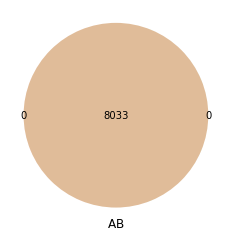

In [ ]:
#hide

import os
import pandas as pd
import shutil
import matplotlib_venn
import alphaquant.diffquant_utils as aqutils


input_file = "./test_data/input_table_formats/spectronaut.frgions.large.tsv"
outdir = "./test_data/input_table_formats/loading_comparisons"

file_default = "default_out.tsv"
file_dask_proc = "dask_proc_out.tsv"

def test_table_loadings(input_file, outdir, file_default, file_dask_proc):
    if not os.path.exists(outdir):
        os.mkdir(outdir)
        os.chdir(outdir)

    input_type, config_dict_for_type, sep = aqutils.get_input_type_and_config_dict(input_file)

    aqutils.reformat_and_write_longtable_according_to_config_new(input_file,outfile_name=file_dask_proc,config_dict=config_dict_for_type, enforce_largefile_processing=True, chunksize=10_000)
    aqutils.reformat_and_write_longtable_according_to_config_new(input_file,outfile_name=file_default,config_dict=config_dict_for_type, chunksize=10_000)

    df_default = pd.read_csv(file_default, sep = "\t")

    df_dask_proc = pd.read_csv(file_dask_proc, sep = "\t")


    assert df_default.equals(df_dask_proc)

    matplotlib_venn.venn2([set(df_default["ion"]), set(df_dask_proc["ion"])])

    os.remove(file_default)
    os.remove(file_dask_proc)
    shutil.rmtree(outdir)


test_table_loadings(input_file, outdir, file_default, file_dask_proc)

In [ ]:
#hide

import alphaquant.diffquant_utils as aqutils
import alphaquant.diff_analysis_manager as diffmgr
import os
import shutil


print(os.path.abspath(os.path.join("..", "..")))

tabledir = os.path.join( "test_data", "input_table_formats")
results_dir = os.path.join("test_data", "results")



input_file = os.path.join(tabledir,"diann.tsv" )
#input_file = os.path.join(tabledir, "spectronaut.tsv")
#input_file = os.path.join(tabledir, "spectronaut_frgion.tsv")
#input_file = os.path.join(tabledir, "mq_peptides.txt")

samplemap_file = os.path.join(tabledir, "samplemap.diann.tsv")
#samplemap_file = os.path.join(tabledir, "samplemap.spectronaut.tsv")
#samplemap_file = os.path.join(tabledir, "samplemap.spectronaut.frgions.tsv")
#samplemap_file = os.path.join(tabledir, "samplemap.mq.tsv")

#import the input table once the input and the results folder are specified. 
# The function automatically recognizes the format (Currently MQ, Spectronaut, DIA-NN configured)
input_data = aqutils.import_data(input_file)
display(input_data)

#get sample names from the imported table
samplenames = aqutils.get_samplenames(input_data)
display(samplenames)

#load the samplemap dataframe (in case the user uploads a file. Basically a pandas import + separator check)
samplemap_df = aqutils.load_samplemap(samplemap_file)
display(samplemap_df)

#compare samplemap and actual table, merge & logtransform intensities
input_processed, samplemap_df_processed = aqutils.prepare_loaded_tables(input_data, samplemap_df)

display(input_processed)
display(samplemap_df_processed)


#run the pipeline, plots are deactivated (runtime_plots actually set False as default also)
diffmgr.run_pipeline(input_df = input_processed, samplemap_df = samplemap_df_processed, results_dir = results_dir,runtime_plots=False, condpair_combinations=[('H100Y1', 'H100Y100')]) #these condpair combiantions now just work for DIA-NN
shutil.rmtree(results_dir) 

/Users/constantin
recols maxquant_peptides	 ['Mass', 'Sequence', 'Leading razor protein', 'Reverse', 'Potential contaminant']
recols diann_fragion_isotopes	 ['Precursor.Charge', 'Ms1.Area', 'Run', 'Stripped.Sequence', 'Modified.Sequence', 'Protein.Group', 'Fragment.Quant.Raw']


Run,protein,ion,20210407_tims03_Evo03_PaSk_SA_HeLa_100ng_Yeast_100ng_S2-A10_1_24557,20210407_tims03_Evo03_PaSk_SA_HeLa_100ng_Yeast_100ng_S2-A11_1_24560,20210407_tims03_Evo03_PaSk_SA_HeLa_100ng_Yeast_100ng_S2-A12_1_24563,20210407_tims03_Evo03_PaSk_SA_HeLa_100ng_Yeast_100ng_S2-A1_1_24530,20210407_tims03_Evo03_PaSk_SA_HeLa_100ng_Yeast_100ng_S2-A2_1_24533,20210407_tims03_Evo03_PaSk_SA_HeLa_100ng_Yeast_100ng_S2-A3_1_24536,20210407_tims03_Evo03_PaSk_SA_HeLa_100ng_Yeast_100ng_S2-A4_1_24539,20210407_tims03_Evo03_PaSk_SA_HeLa_100ng_Yeast_100ng_S2-A5_1_24542,...,20210407_tims03_Evo03_PaSk_SA_HeLa_200ng_Yeast_2ng_S2-C12_1_24565,20210407_tims03_Evo03_PaSk_SA_HeLa_200ng_Yeast_2ng_S2-C1_1_24532,20210407_tims03_Evo03_PaSk_SA_HeLa_200ng_Yeast_2ng_S2-C2_1_24535,20210407_tims03_Evo03_PaSk_SA_HeLa_200ng_Yeast_2ng_S2-C3_1_24538,20210407_tims03_Evo03_PaSk_SA_HeLa_200ng_Yeast_2ng_S2-C4_1_24541,20210407_tims03_Evo03_PaSk_SA_HeLa_200ng_Yeast_2ng_S2-C5_1_24544,20210407_tims03_Evo03_PaSk_SA_HeLa_200ng_Yeast_2ng_S2-C6_1_24547,20210407_tims03_Evo03_PaSk_SA_HeLa_200ng_Yeast_2ng_S2-C7_1_24550,20210407_tims03_Evo03_PaSk_SA_HeLa_200ng_Yeast_2ng_S2-C8_1_24553,20210407_tims03_Evo03_PaSk_SA_HeLa_200ng_Yeast_2ng_S2-C9_1_24556
0,A0A087WTG0;A0A087WVV8;A0A087WWQ1;A0A087WY62;A0...,SEQ_AAINILEINEK_MOD_AAINILEINEK_CHARGE_2_FRGIO...,0.00,0.00,0.000,0.0,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,10520.10,0.00,0.00,0.00,8339.06,0.00
1,A0A087WTG0;A0A087WVV8;A0A087WWQ1;A0A087WY62;A0...,SEQ_AAINILEINEK_MOD_AAINILEINEK_CHARGE_2_FRGIO...,0.00,0.00,0.000,0.0,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,1257.01,0.00,0.00,0.00,1055.01,0.00
2,A0A087WTG0;A0A087WVV8;A0A087WWQ1;A0A087WY62;A0...,SEQ_AAINILEINEK_MOD_AAINILEINEK_CHARGE_2_FRGIO...,0.00,0.00,0.000,0.0,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,5372.04,0.00,0.00,0.00,5333.04,0.00
3,A0A087WTG0;A0A087WVV8;A0A087WWQ1;A0A087WY62;A0...,SEQ_AAINILEINEK_MOD_AAINILEINEK_CHARGE_2_FRGIO...,0.00,0.00,0.000,0.0,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,3564.02,0.00,0.00,0.00,3893.03,0.00
4,A0A087WTG0;A0A087WVV8;A0A087WWQ1;A0A087WY62;A0...,SEQ_AAINILEINEK_MOD_AAINILEINEK_CHARGE_2_FRGIO...,0.00,0.00,0.000,0.0,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,1437.01,0.00,0.00,0.00,1272.01,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4370,Q9Y6Y8,SEQ_AAYWEEEPAEVR_MOD_AAYWEEEPAEVR_CHARGE_2_FRG...,2595.03,2439.02,3088.020,0.0,3036.03,3641.03,2459.02,2262.02,...,3102.03,3040.03,4341.03,3998.04,3599.03,3949.04,3713.04,2573.02,3106.02,4178.04
4371,Q9Y6Y8,SEQ_AAYWEEEPAEVR_MOD_AAYWEEEPAEVR_CHARGE_2_FRG...,1450.01,1216.01,692.006,0.0,1565.01,1416.01,1552.01,1163.01,...,1282.01,1160.01,1801.02,1743.01,1972.02,2886.03,1933.02,1442.01,1697.01,1370.01
4372,Q9Y6Y8,SEQ_AAYWEEEPAEVR_MOD_AAYWEEEPAEVR_CHARGE_2_FRG...,3372.03,1857.02,1738.020,0.0,2646.02,2235.02,1884.02,2938.03,...,3896.04,2311.02,2792.03,2657.02,3177.03,2592.02,2435.02,2202.02,2853.03,2137.02
4373,Q9Y6Y8,SEQ_AAYWEEEPAEVR_MOD_AAYWEEEPAEVR_CHARGE_2_FRG...,13536.10,8181.08,5436.060,0.0,7421.06,11342.10,10649.10,5571.04,...,1913.02,2114.02,2218.02,2310.02,1623.01,2483.02,1762.01,2083.01,1878.02,1009.01


['20210407_tims03_Evo03_PaSk_SA_HeLa_100ng_Yeast_100ng_S2-A10_1_24557',
 '20210407_tims03_Evo03_PaSk_SA_HeLa_100ng_Yeast_100ng_S2-A11_1_24560',
 '20210407_tims03_Evo03_PaSk_SA_HeLa_100ng_Yeast_100ng_S2-A12_1_24563',
 '20210407_tims03_Evo03_PaSk_SA_HeLa_100ng_Yeast_100ng_S2-A1_1_24530',
 '20210407_tims03_Evo03_PaSk_SA_HeLa_100ng_Yeast_100ng_S2-A2_1_24533',
 '20210407_tims03_Evo03_PaSk_SA_HeLa_100ng_Yeast_100ng_S2-A3_1_24536',
 '20210407_tims03_Evo03_PaSk_SA_HeLa_100ng_Yeast_100ng_S2-A4_1_24539',
 '20210407_tims03_Evo03_PaSk_SA_HeLa_100ng_Yeast_100ng_S2-A5_1_24542',
 '20210407_tims03_Evo03_PaSk_SA_HeLa_100ng_Yeast_100ng_S2-A6_1_24545',
 '20210407_tims03_Evo03_PaSk_SA_HeLa_100ng_Yeast_100ng_S2-A7_1_24548',
 '20210407_tims03_Evo03_PaSk_SA_HeLa_100ng_Yeast_100ng_S2-A8_1_24551',
 '20210407_tims03_Evo03_PaSk_SA_HeLa_100ng_Yeast_100ng_S2-A9_1_24554',
 '20210407_tims03_Evo03_PaSk_SA_HeLa_100ng_Yeast_1ng_S2-B10_1_24558',
 '20210407_tims03_Evo03_PaSk_SA_HeLa_100ng_Yeast_1ng_S2-B11_1_24561',
 '202

,sample,condition
0,20210407_tims03_Evo03_PaSk_SA_HeLa_100ng_Yeast...,H100Y100
1,20210407_tims03_Evo03_PaSk_SA_HeLa_100ng_Yeast...,H100Y100
2,20210407_tims03_Evo03_PaSk_SA_HeLa_100ng_Yeast...,H100Y100
3,20210407_tims03_Evo03_PaSk_SA_HeLa_100ng_Yeast...,H100Y100
4,20210407_tims03_Evo03_PaSk_SA_HeLa_100ng_Yeast...,H100Y100
5,20210407_tims03_Evo03_PaSk_SA_HeLa_100ng_Yeast...,H100Y100
6,20210407_tims03_Evo03_PaSk_SA_HeLa_100ng_Yeast...,H100Y100
7,20210407_tims03_Evo03_PaSk_SA_HeLa_100ng_Yeast...,H100Y100
8,20210407_tims03_Evo03_PaSk_SA_HeLa_100ng_Yeast...,H100Y100
9,20210407_tims03_Evo03_PaSk_SA_HeLa_100ng_Yeast...,H100Y100


Run,protein,20210407_tims03_Evo03_PaSk_SA_HeLa_100ng_Yeast_100ng_S2-A10_1_24557,20210407_tims03_Evo03_PaSk_SA_HeLa_100ng_Yeast_100ng_S2-A11_1_24560,20210407_tims03_Evo03_PaSk_SA_HeLa_100ng_Yeast_100ng_S2-A12_1_24563,20210407_tims03_Evo03_PaSk_SA_HeLa_100ng_Yeast_100ng_S2-A1_1_24530,20210407_tims03_Evo03_PaSk_SA_HeLa_100ng_Yeast_100ng_S2-A2_1_24533,20210407_tims03_Evo03_PaSk_SA_HeLa_100ng_Yeast_100ng_S2-A3_1_24536,20210407_tims03_Evo03_PaSk_SA_HeLa_100ng_Yeast_100ng_S2-A4_1_24539,20210407_tims03_Evo03_PaSk_SA_HeLa_100ng_Yeast_100ng_S2-A5_1_24542,20210407_tims03_Evo03_PaSk_SA_HeLa_100ng_Yeast_100ng_S2-A6_1_24545,...,20210407_tims03_Evo03_PaSk_SA_HeLa_200ng_Yeast_2ng_S2-C12_1_24565,20210407_tims03_Evo03_PaSk_SA_HeLa_200ng_Yeast_2ng_S2-C1_1_24532,20210407_tims03_Evo03_PaSk_SA_HeLa_200ng_Yeast_2ng_S2-C2_1_24535,20210407_tims03_Evo03_PaSk_SA_HeLa_200ng_Yeast_2ng_S2-C3_1_24538,20210407_tims03_Evo03_PaSk_SA_HeLa_200ng_Yeast_2ng_S2-C4_1_24541,20210407_tims03_Evo03_PaSk_SA_HeLa_200ng_Yeast_2ng_S2-C5_1_24544,20210407_tims03_Evo03_PaSk_SA_HeLa_200ng_Yeast_2ng_S2-C6_1_24547,20210407_tims03_Evo03_PaSk_SA_HeLa_200ng_Yeast_2ng_S2-C7_1_24550,20210407_tims03_Evo03_PaSk_SA_HeLa_200ng_Yeast_2ng_S2-C8_1_24553,20210407_tims03_Evo03_PaSk_SA_HeLa_200ng_Yeast_2ng_S2-C9_1_24556
ion,,,,,,,,,,,,,,,,,,,,,
SEQ_AAINILEINEK_MOD_AAINILEINEK_CHARGE_2_FRGION_0_,A0A087WTG0;A0A087WVV8;A0A087WWQ1;A0A087WY62;A0...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,13.360861,NaN,NaN,NaN,13.025669,NaN
SEQ_AAINILEINEK_MOD_AAINILEINEK_CHARGE_2_FRGION_1_,A0A087WTG0;A0A087WVV8;A0A087WWQ1;A0A087WY62;A0...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,10.295780,NaN,NaN,NaN,10.043041,NaN
SEQ_AAINILEINEK_MOD_AAINILEINEK_CHARGE_2_FRGION_2_,A0A087WTG0;A0A087WVV8;A0A087WWQ1;A0A087WY62;A0...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,12.391254,NaN,NaN,NaN,12.380742,NaN
SEQ_AAINILEINEK_MOD_AAINILEINEK_CHARGE_2_FRGION_3_,A0A087WTG0;A0A087WVV8;A0A087WWQ1;A0A087WY62;A0...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,11.799290,NaN,NaN,NaN,11.926678,NaN
SEQ_AAINILEINEK_MOD_AAINILEINEK_CHARGE_2_FRGION_4_,A0A087WTG0;A0A087WVV8;A0A087WWQ1;A0A087WY62;A0...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,10.488854,NaN,NaN,NaN,10.312894,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SEQ_AAYWEEEPAEVR_MOD_AAYWEEEPAEVR_CHARGE_2_FRGION_2_,Q9Y6Y8,11.341536,11.252086,11.592466,NaN,11.567970,11.830131,11.263868,11.143396,11.254450,...,11.598997,11.569870,12.083822,11.965077,11.813392,11.947286,11.858385,11.329247,11.600851,12.028611
SEQ_AAYWEEEPAEVR_MOD_AAYWEEEPAEVR_CHARGE_2_FRGION_3_,Q9Y6Y8,10.501847,10.247939,9.434641,NaN,10.611956,10.467616,10.599922,10.183648,10.295780,...,10.324192,10.179922,10.814598,10.767365,10.945458,11.494871,10.916641,10.493865,10.728779,10.419971
SEQ_AAYWEEEPAEVR_MOD_AAYWEEEPAEVR_CHARGE_2_FRGION_4_,Q9Y6Y8,11.719402,10.858774,10.763229,NaN,11.369608,11.126072,10.879599,11.520633,11.670227,...,11.927793,11.174314,11.447099,11.375593,11.633463,11.339861,11.249718,11.104612,11.478279,11.061385


,sample,condition
0,20210407_tims03_Evo03_PaSk_SA_HeLa_100ng_Yeast...,H100Y100
1,20210407_tims03_Evo03_PaSk_SA_HeLa_100ng_Yeast...,H100Y100
2,20210407_tims03_Evo03_PaSk_SA_HeLa_100ng_Yeast...,H100Y100
3,20210407_tims03_Evo03_PaSk_SA_HeLa_100ng_Yeast...,H100Y100
4,20210407_tims03_Evo03_PaSk_SA_HeLa_100ng_Yeast...,H100Y100
5,20210407_tims03_Evo03_PaSk_SA_HeLa_100ng_Yeast...,H100Y100
6,20210407_tims03_Evo03_PaSk_SA_HeLa_100ng_Yeast...,H100Y100
7,20210407_tims03_Evo03_PaSk_SA_HeLa_100ng_Yeast...,H100Y100
8,20210407_tims03_Evo03_PaSk_SA_HeLa_100ng_Yeast...,H100Y100
9,20210407_tims03_Evo03_PaSk_SA_HeLa_100ng_Yeast...,H100Y100


('H100Y1', 'H100Y100')
start processeing condpair ('H100Y1', 'H100Y100')
normalized within conditions
median 0.2088401165472309, mode 0.4966443356624599
using mode for shift
shift cond 2 by -0.4966443356624599
t_ion2nonan_sw 0.0058858394622802734
t_intensity_selection 0.5090887546539307
t_ion2nonan_sw 0.005160093307495117
t_intensity_selection 0.4803941249847412
checked 0 of 1949 ions
checked 0 of 242 prots
checked 100 of 242 prots
checked 200 of 242 prots


recols maxquant_peptides	 ['Mass', 'Sequence', 'Leading razor protein', 'Reverse', 'Potential contaminant']
recols diann_fragion_isotopes	 ['Precursor.Charge', 'Ms1.Area', 'Run', 'Stripped.Sequence', 'Modified.Sequence', 'Protein.Group', 'Fragment.Quant.Raw']
recols diann_fragion_isotopes_corrected	 ['Precursor.Charge', 'Ms1.Area', 'Run', 'Stripped.Sequence', 'Modified.Sequence', 'Protein.Group', 'Fragment.Quant.Corrected']
recols diann_fragion	 ['Precursor.Charge', 'Run', 'Stripped.Sequence', 'Modified.Sequence', 'Protein.Group', 'Fragment.Quant.Corrected']
recols diann_precursor	 ['Run', 'Protein.Group', 'Precursor.Id', 'Precursor.Quantity']
recols diann_sequence	 ['Precursor.Normalised', 'Run', 'Stripped.Sequence', 'Protein.Group', 'Quantity.Quality']
recols diann_protein	 ['Run', 'Protein.Group', 'Protein.Names', 'PG.MaxLFQ']
recols spectronaut_ptm_fragion_isotopes	 ['PEP.StrippedSequence', 'F.FrgIon', 'F.FrgLossType', 'F.Charge', 'R.Label', 'ptm_mapped_modseq', 'ptm_id', 'FG.MS1Is

,R.Label,EG.ModifiedPeptide,FG.Charge,FG.Quantity,compareID
0,E_D170331_S209-S-1-240min_MHRM_R01_T0.htrms,_LNVLPVDVLTR_,2,95427.601562,_LNVLPVDVLTR_2E_D170331_S209-S-1-240min_MHRM_R...
1,E_D170331_S209-S-1-240min_MHRM_R01_T0.htrms,_LNVLPVDVLTR_,2,95427.601562,_LNVLPVDVLTR_2E_D170331_S209-S-1-240min_MHRM_R...
2,E_D170331_S209-S-1-240min_MHRM_R01_T0.htrms,_LNVLPVDVLTR_,2,95427.601562,_LNVLPVDVLTR_2E_D170331_S209-S-1-240min_MHRM_R...
3,E_D170331_S209-S-1-240min_MHRM_R01_T0.htrms,_LNVLPVDVLTR_,2,95427.601562,_LNVLPVDVLTR_2E_D170331_S209-S-1-240min_MHRM_R...
4,E_D170331_S209-S-1-240min_MHRM_R01_T0.htrms,_LNVLPVDVLTR_,2,95427.601562,_LNVLPVDVLTR_2E_D170331_S209-S-1-240min_MHRM_R...
...,...,...,...,...,...
9994,E_D170331_S209-S-1-240min_MHRM_R01_T0.htrms,_GC[Carbamidomethyl (C)]VITISGR_,2,110807.851562,_GC[Carbamidomethyl (C)]VITISGR_2E_D170331_S20...
9995,E_D170331_S209-S-1-240min_MHRM_R01_T0.htrms,_GC[Carbamidomethyl (C)]VITISGR_,2,110807.851562,_GC[Carbamidomethyl (C)]VITISGR_2E_D170331_S20...
9996,E_D170331_S209-S-1-240min_MHRM_R01_T0.htrms,_GC[Carbamidomethyl (C)]VITISGR_,2,110807.851562,_GC[Carbamidomethyl (C)]VITISGR_2E_D170331_S20...
9997,E_D170331_S209-S-1-240min_MHRM_R01_T0.htrms,_GC[Carbamidomethyl (C)]VITISGR_,2,110807.851562,_GC[Carbamidomethyl (C)]VITISGR_2E_D170331_S20...


['_AAAAASAAGPGGLVAGKEEK_2E_D170331_S209-S-1-240min_MHRM_R01_T0.htrms', '_AAAAASAAGPGGLVAGKEEK_3E_D170331_S209-S-1-240min_MHRM_R01_T0.htrms', '_AAAAASAAGPGGLVAGK_2E_D170331_S209-S-1-240min_MHRM_R01_T0.htrms', '_AAANFSDR_2E_D170331_S209-S-1-240min_MHRM_R01_T0.htrms', '_AAAPEKPDAEHDAPQFIEPLDSIDR_4E_D170331_S209-S-1-240min_MHRM_R01_T0.htrms', '_AAFDVIVR_2E_D170331_S209-S-1-240min_MHRM_R01_T0.htrms', '_AAGAILK_1E_D170331_S209-S-1-240min_MHRM_R01_T0.htrms', '_AAGEHIASSGK_2E_D170331_S209-S-1-240min_MHRM_R01_T0.htrms', '_AAGIWYEHR_3E_D170331_S209-S-1-240min_MHRM_R01_T0.htrms', '_AALAATGAASGGGGGGGGAGSR_2E_D170331_S209-S-1-240min_MHRM_R01_T0.htrms']
['_AAAAASAAGPGGLVAGKEEK_2E_D170331_S209-S-1-240min_MHRM_R01_T0.htrms', '_AAAAASAAGPGGLVAGKEEK_3E_D170331_S209-S-1-240min_MHRM_R01_T0.htrms', '_AAAAASAAGPGGLVAGK_2E_D170331_S209-S-1-240min_MHRM_R01_T0.htrms', '_AAANFSDR_2E_D170331_S209-S-1-240min_MHRM_R01_T0.htrms', '_AAAPEKPDAEHDAPQFIEPLDSIDR_4E_D170331_S209-S-1-240min_MHRM_R01_T0.htrms', '_AAFDVIVR_

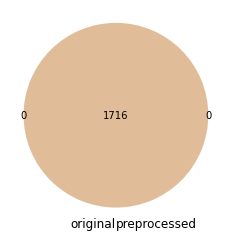

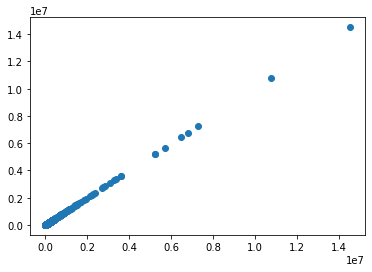

correlation between both processings: 0.9999999999999998


In [ ]:
#hide
import yaml
import pandas as pd
import numpy as np
from matplotlib_venn import venn2
import matplotlib.pyplot as plt

def compare_generic_table_with_original(preprocessed_input_df, original_input_file, config_yaml,input_typename_config, sep = "\t"):
    id2quant_orig, id2quant_preproc = get_processed_original_id2quant_maps(preprocessed_input_df, original_input_file, config_yaml,input_typename_config)
    keys_orig = set(id2quant_orig.keys())
    keys_preproc = set(id2quant_preproc.keys())
    keydiff = keys_preproc.difference(keys_orig)
    keys_orig = sorted(keys_orig)
    keys_preproc = sorted(keys_preproc)
    print(list(keys_orig)[:10])
    print(list(keys_preproc)[:10])
    
    
    assert(len(keydiff)==0) #check that all keys in the preprocessed set are part of the original set

    venn2([set(id2quant_orig.keys()), set(id2quant_preproc.keys())], ["original", "preprocessed"])
    
    quantvec_orig = np.array([id2quant_orig.get(x)for x in id2quant_preproc.keys()])
    quantvec_preproc = np.array([id2quant_preproc.get(x)for x in id2quant_preproc.keys()])
    unequal_quant = [id2quant_orig.get(x)!=id2quant_preproc.get(x) for x in id2quant_preproc.keys()]
    unequal_quant_scaled = [id2quant_orig.get(x)*10000!=id2quant_preproc.get(x) for x in id2quant_preproc.keys()]
    print(sum(unequal_quant))
    print(sum(unequal_quant_scaled))
    plt.show()
    plt.scatter(quantvec_orig, quantvec_preproc)
    plt.show()
    corrcoeff = np.corrcoef(quantvec_orig,quantvec_preproc)[0][1]
    print(f"correlation between both processings: {corrcoeff}")
    assert(corrcoeff>0.999)



def get_processed_original_id2quant_maps(preprocessed_input_df, original_input_file, config_yaml,input_typename_config, sep = "\t"):
    config_all = yaml.safe_load(open(config_yaml, 'r'))
    config_dict = config_all.get(input_typename_config)
    id_cols = config_dict.get("ion_cols") + [config_dict.get("sample_ID")]
    quant_col = list(config_dict.get("quant_ID").values())
    id2quant_orig = get_id2quant_original(original_input_file, id_cols, quant_col, sep)
    id2quant_preproc = get_id2quant_processed(preprocessed_input_df, id_cols, quant_col)
    return id2quant_orig, id2quant_preproc


def get_id2quant_original(original_input_file, id_cols, quant_col, sep):
    print(id_cols)
    print(id_cols+quant_col)
    orig_df = pd.read_csv(original_input_file, sep=sep, usecols= id_cols+quant_col)
    orig_df["compareID"] = orig_df[id_cols].astype('string').sum(axis = 1)
    display(orig_df)
    id2quant = dict(zip(orig_df["compareID"], orig_df[quant_col[0]]))
    id2quant = {k: round(v,3) for k, v in id2quant.items()}
    return id2quant


def get_id2quant_processed(preprocessed_input_df, id_cols, quant_col):
    compare_IDs = []
    quantvals = []
    for column in preprocessed_input_df.columns:
        if(column == "protein"):
            continue
        id = pd.Series([column for x in range(len(preprocessed_input_df.index))]).to_numpy()[0]
        reformated_pep_id = [x.split("_MOD_")[1].replace("_CHARGE_", "")[:-1]+id for x in preprocessed_input_df.index]
        compare_IDs.extend(reformated_pep_id)

        quantvals.extend(list(preprocessed_input_df[column]))
    
    id2quant = dict(zip(compare_IDs, quantvals))
    id2quant = {k: round(2**v,3) for k, v in id2quant.items() if ~np.isnan(v)}
    return id2quant


import alphaquant.diffquant_utils as aqutils
import os


input_file = os.path.join(tabledir, "spectronaut.tsv")
samplemap_file = os.path.join(tabledir, "samplemap.spectronaut.tsv")


input_data = aqutils.import_data(input_file)
samplemap_df = aqutils.load_samplemap(samplemap_file)
input_processed, samplemap_df_processed = aqutils.prepare_loaded_tables(input_data, samplemap_df)
compare_generic_table_with_original(input_processed, input_file, os.path.join("intable_config.yaml"), "spectronaut_precursor_v2")
